In [1]:
pwd

'/Users/rohit/Desktop/ML_mini_project'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])

/var/folders/w1/2m72dwjs3cq6t8st6646q9dw0000gn/T/ipykernel_1717/1475962123.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])
/var/folders/w1/2m72dwjs3cq6t8st6646q9dw0000gn/T/ipykernel_1717/1475962123.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])


In [4]:
df.shape

(2075259, 8)

In [5]:
df.set_index('datetime', inplace=True)
df = df.resample('D').sum()

In [6]:
# Handle missing values
df.fillna(method='ffill', inplace=True)

In [7]:
# Normalization
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Global_active_power']])


In [8]:
# Step 2: Prepare Data for LSTM
# Create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [9]:
time_steps = 7  # Use past 7 days to predict the next day
X, y = create_sequences(df_scaled, time_steps)

In [10]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
#Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 4: Model Evaluation
y_pred = model.predict(X_test)

Epoch 1/50
36/36 [==============================] - 1s 4ms/step - loss: 0.0374 - val_loss: 0.0084
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0070
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0070
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0069
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0069
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0073
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0069
Epoch 8/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 9/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0069
Epoch 10/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 11/50
36/36 [

In [16]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 0.05502673830325974, RMSE: 0.07721722014162626


In [12]:
from sklearn.metrics import r2_score
print(f'r2_score : {r2_score(y_test,y_pred)}')

r2_score : 0.45216446554959666


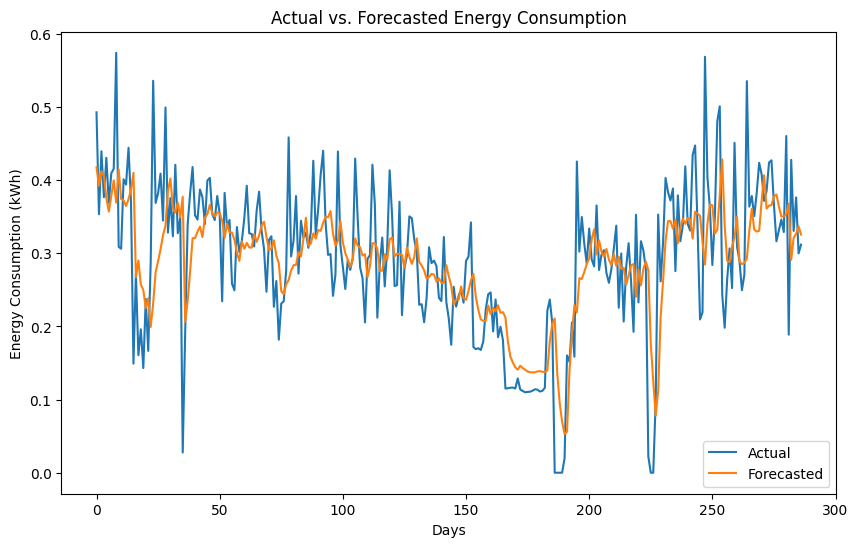

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Forecasted')
plt.xlabel('Days')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Actual vs. Forecasted Energy Consumption')
plt.legend()
plt.show()

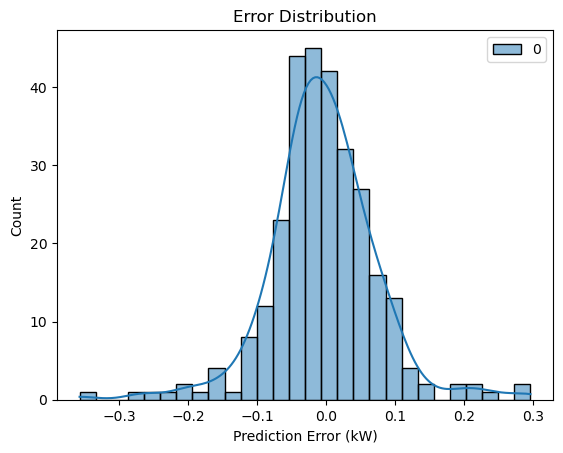

In [13]:
import seaborn as sns

errors = y_test - y_pred
sns.histplot(errors, kde=True)
plt.title("Error Distribution")
plt.xlabel("Prediction Error (kW)")
plt.show()


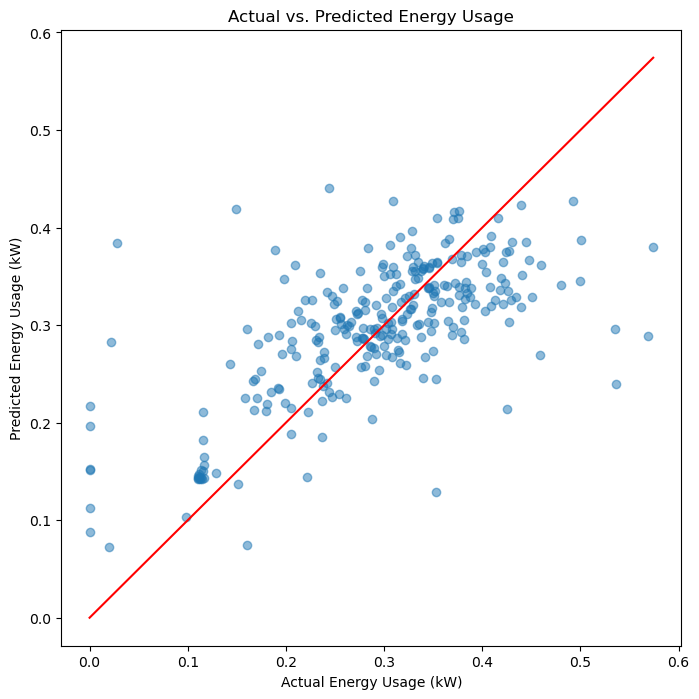

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Actual vs. Predicted Energy Usage")
plt.xlabel("Actual Energy Usage (kW)")
plt.ylabel("Predicted Energy Usage (kW)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()
